<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.DigitRecognizer/blob/main/0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Stretch tasks:
    - Create a baseline with Batch Normalization, without looking on the Internet
    - Create a baseline with Dropout, without looking on the Internet
    - Implement classic architectures (AlexNet, VGG), without looking
    - Implement model checkpoint callbacks (save every epoch)
    - Write NN with functional API, not looking on the Internet
    - Enwrap your FFNN for grid search CV and find the best architecture
    - Stretch pants approach
    - Correct initialization strategies for different activation functions
    - Use functools.partial in building sequential model
    - Transfer learning

# Imports

In [1]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
import numpy as np

## Pep 8 standard

In [2]:
%%capture 
try: 
    from nbpep8.nbpep8 import pep8 
except ModuleNotFoundError: 
    !pip install pycodestyle 
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8

# Helper functions

In [3]:
def plot_history(history_):
    _, ax = plt.subplots(1, 2, figsize=(8, 3))

    ax[0].plot(
        history.history['loss'],
        label='loss'
    )
    ax[0].plot(
        history.history['val_loss'],
        label='val_loss'
    )

    ax[0].legend()

    ax[1].plot(
        history.history['accuracy'],
        label='acc'
    )
    ax[1].plot(
        history.history['val_accuracy'],
        label='val_acc'
    )
    ax[1].legend()

## Custom packages

In [4]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [5]:
import importlib
import path_manager
import sklearn_utils

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        path_manager,
        sklearn_utils
        # other modules
    ]
)

from path_manager import PathManager
from sklearn_utils import (
    nan_statistics,
    visualize_datasets_distributions
)

# Setup paths

In [6]:
drive.mount('/content/gdrive', force_remount=True)  # force_remount=True
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 'baseline'
MODELS_TRIAL = 'baseline'
COMPETITION_PATH = gdrive_path + 'ML/Competitions/3.DigitRecognizer/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/3.DigitRecognizer/Data/preproc_trial_baseline already exists
/content/gdrive/MyDrive/ML/Competitions/3.DigitRecognizer/Models/trial_baseline already exists


# Download the data

In [7]:
df_train = pd.read_csv(manager.train_path)
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_test = pd.read_csv(manager.test_path)
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Quick data exporation

## Nan values

In [ ]:
assert not df_train.isna().any().any()
assert not df_test.isna().any().any()

In [ ]:
import numpy as np
print(np.max(df_train.values), np.min(df_train.values))
print(np.max(df_test.values), np.min(df_test.values))

255 0
255 0


## Class balance

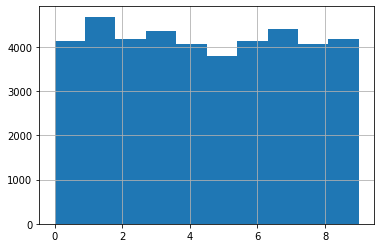

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
df_train['label'].hist(ax=ax)

# Create train, validation and test sets

In [9]:
from sklearn.model_selection import train_test_split

TRAINVAL_SIZE = 0.8
RANDOM_STATE = 42

df_trainval, df_test_sample = train_test_split(
    df_train,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_train['label']
)
df_trainval.shape, df_test.shape

((33600, 785), (28000, 784))

In [10]:
TRAIN_SIZE = 0.8

df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['label']
)
df_train.shape, df_val.shape

((26880, 785), (6720, 785))

# Data exploration (from now on, on train set)

In [ ]:
vals = df_train.values[0, 1:]
type(vals)

numpy.ndarray

(-0.5, 27.5, 27.5, -0.5)

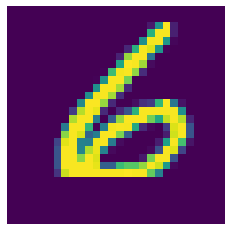

In [ ]:
plt.imshow(vals.reshape(28, 28))
plt.axis('off')

# Data preparation

In [11]:
df_test.shape, df_test_sample.shape

((28000, 784), (8400, 785))

In [12]:
df_train.values[:, 1:] = df_train.values[:, 1:] / 255.0
df_val.values[:, 1:] = df_val.values[:, 1:] / 255.0
df_test_sample.values[:, 1:] = df_test_sample.values[:, 1:] / 255.0

df_test.values[:, :] = df_test.values[:, :] / 255.0

In [13]:
assert df_train.values[:, 1:].max() <= 1.0
assert df_test.values.max() <= 1.0
assert df_test_sample.values[:, 1:].max() <= 1.0
assert df_val.values[:, 1:].max() <= 1.0

In [14]:
X_train = df_train.values[:, 1:]
Y_train = df_train.values[:, 0]

X_validation = df_val.values[:, 1:]
Y_validation = df_val.values[:, 0]

X_test_sample = df_test_sample.values[:, 1:]
Y_test_sample = df_test_sample.values[:, 0]

X_test = df_test.values[:, :]

assert X_train.shape[1] == X_validation.shape[1] == X_test.shape[1]
assert (np.unique(Y_train) == np.unique(Y_validation)).all()
assert (np.unique(Y_validation) == np.unique(Y_test_sample)).all()

In [15]:
assert np.max(X_train) == 1
assert np.max(X_validation) == 1
assert np.max(X_test_sample) == 1
assert np.max(X_test) == 1

In [40]:
def proc(arr):
    arr = np.dstack([arr] * 3)
    arr = arr.reshape(-1, 28, 28, 3)
    return arr

X_train = proc(X_train)
X_validation = proc(X_validation)
X_test_sample = proc(X_test_sample)
X_test = proc(X_test)

In [105]:
# from keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import img_to_array, array_to_img

def resize(arr):
    # Resize the images 48*48 as required by VGG16
    arr = np.asarray(
        [img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in arr])
    return arr


X_train = resize(X_train)
X_train.shape

(26880, 48, 48, 3)

In [106]:
X_validation = resize(X_validation)
X_test_sample = resize(X_test_sample)
X_test = resize(X_test)

In [107]:
X_train_subsample, _, Y_train_subsample, _ = train_test_split(
    X_train,
    Y_train,
    train_size=0.8,
    random_state=RANDOM_STATE,
    stratify=Y_train
)

X_validation_subsample, _, Y_validation_subsample, _ = \
    train_test_split(
        X_validation,
        Y_validation,
        train_size=0.1,
        random_state=RANDOM_STATE,
        stratify=Y_validation
    )

In [108]:
X_train_subsample.shape

(21504, 48, 48, 3)

In [109]:
assert np.max(X_train_subsample) == 1
assert np.max(X_validation_subsample) == 1

# Save data

In [ ]:
manager.save_to_csv(
    df_train,
    manager.data_trial_path,
    'train_processed.csv'
)

manager.save_to_csv(
    df_val,
    manager.data_trial_path,
    'val_processed.csv'
)

In [ ]:
manager.save_to_csv(
    df_test_sample,
    manager.data_trial_path,
    'test_sample_processed.csv'
)

In [ ]:
manager.save_to_csv(
    df_test,
    manager.data_trial_path,
    'test_processed.csv'
)

# Model preparation

## Sequential baseline

In [135]:
baseline_model = Sequential(
    [
        layers.Input(shape=(784, )),
        layers.Dense(units=784, activation='relu'),
        layers.Dense(units=100, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(units=10, activation='softmax')
    ]
)

In [136]:
baseline_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [137]:
history = baseline_model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=32,
    epochs=50,
    callbacks=[EarlyStopping(patience=3)]
)

Epoch 1/50
840/840 [==============================] - 8s 9ms/step - loss: 2.1838 - accuracy: 0.2597 - val_loss: 2.0470 - val_accuracy: 0.3622
Epoch 2/50
840/840 [==============================] - 10s 12ms/step - loss: 1.9257 - accuracy: 0.3665 - val_loss: 1.8353 - val_accuracy: 0.3869
Epoch 3/50
840/840 [==============================] - 10s 12ms/step - loss: 1.7641 - accuracy: 0.3919 - val_loss: 1.7506 - val_accuracy: 0.3917
Epoch 4/50
840/840 [==============================] - 8s 10ms/step - loss: 1.6922 - accuracy: 0.4084 - val_loss: 1.7108 - val_accuracy: 0.3961
Epoch 5/50
840/840 [==============================] - 7s 8ms/step - loss: 1.6499 - accuracy: 0.4179 - val_loss: 1.6901 - val_accuracy: 0.4052
Epoch 6/50
840/840 [==============================] - 8s 9ms/step - loss: 1.6219 - accuracy: 0.4207 - val_loss: 1.6825 - val_accuracy: 0.4051
Epoch 7/50
840/840 [==============================] - 11s 13ms/step - loss: 1.6004 - accuracy: 0.4304 - val_loss: 1.6721 - val_accuracy: 0.4024

In [ ]:
baseline_model.evaluate(X_validation, Y_validation)

135/135 [==============================] - 1s 9ms/step - loss: 1.8440 - accuracy: 0.3980


[1.8440223932266235, 0.39804697036743164]

In [ ]:
plot_history(history)

## Baseline CNN

In [ ]:
baseline_cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ]
)

In [ ]:
early_stopper = EarlyStopping(
    patience=2,
    monitor='val_loss',
    mode='min'
)

In [ ]:
baseline_cnn.compile(
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
    optimizer='adam'
)

In [ ]:
history = baseline_cnn.fit(
    X_train.reshape(X_train.shape[0], 28, 28),
    Y_train,
    validation_data=(
        X_validation.reshape(X_validation.shape[0], 28, 28), Y_validation
    ),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopper]
)

Epoch 1/20
538/538 [==============================] - 139s 257ms/step - loss: 1.8171 - accuracy: 0.3576 - val_loss: 1.6499 - val_accuracy: 0.4036
Epoch 2/20
538/538 [==============================] - 144s 269ms/step - loss: 1.6728 - accuracy: 0.4033 - val_loss: 1.6368 - val_accuracy: 0.4129
Epoch 3/20
538/538 [==============================] - 150s 280ms/step - loss: 1.6216 - accuracy: 0.4210 - val_loss: 1.6266 - val_accuracy: 0.4127
Epoch 4/20
538/538 [==============================] - 177s 328ms/step - loss: 1.5871 - accuracy: 0.4271 - val_loss: 1.6272 - val_accuracy: 0.4208
Epoch 5/20
538/538 [==============================] - 145s 269ms/step - loss: 1.5584 - accuracy: 0.4378 - val_loss: 1.6365 - val_accuracy: 0.4225


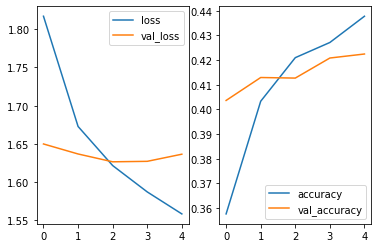

In [ ]:
_, ax = plt.subplots(1, 2)
ax[0].plot(history.history['loss'], label='loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='accuracy')
ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
ax[1].legend()

## Enwrap FFNN into grid search CV

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def build_model(
    n_hidden_layers_=3,
    add_dropout_=True,
    width_=100,
    activation_='relu',
    learning_rate_=0.0001
):
    model = Sequential()
    model.add(Input(shape=(784,)))
    model.add(Dense(28 * 28, activation=activation_))

    for _ in range(n_hidden_layers_ - 2):
        model.add(Dense(units=width_, activation=activation_))
    
    if add_dropout_:
        model.add(Dropout(0.4))

    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=Adam(learning_rate=learning_rate_),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [71]:
keras_reg = KerasRegressor(build_model)

<ipython-input-71-e1ebe08fc635>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_model)


In [72]:
from sklearn.model_selection import GridSearchCV

In [74]:
estimator = GridSearchCV(
    keras_reg,
    {
        'n_hidden_layers_': [4, 6],
        'add_dropout_': [True, False],
    },
    cv=4
)

In [75]:
X_train_subsample.shape, Y_train_subsample.shape, \
    X_validation_subsample.shape, Y_validation_subsample.shape

((21504, 28, 28, 3), (21504,), (672, 28, 28, 3), (672,))

In [76]:
res = estimator.fit(
    X_train_subsample,
    Y_train_subsample,
    epochs=20,
    validation_data=(X_validation_subsample, Y_validation_subsample),
    batch_size=32,
    callbacks=[EarlyStopping(patience=2, mode='min', monitor='val_accuracy')]
)

Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
16 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/keras/wrappers/scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/__auto

Epoch 1/20


ValueError: ignored

In [67]:
res.best_params_, \
    res.best_score_,
    

({'n_hidden_layers_': 4}, -2.3016628424326577)

## CNN keras regressor

In [52]:
from tensorflow.keras.initializers import HeNormal

In [53]:
cnn = Sequential(
    [
        layers.Input(shape=(28, 28, 3)),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        layers.Conv2D(filters=128, kernel_size=3, activation='relu', kernel_initializer=HeNormal()),
        layers.Conv2D(filters=128, kernel_size=3, activation='relu', kernel_initializer=HeNormal()),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        # layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
        # layers.Conv2D(filters=256, kernel_size=3, activation='relu'),
        # layers.MaxPool2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(units=300, activation='relu', kernel_initializer=HeNormal()),
        layers.Dropout(0.4),
        layers.Dense(units=300, activation='relu', kernel_initializer=HeNormal()),
        layers.Dense(units=10, activation='softmax', kernel_initializer=HeNormal())
    ]
)


In [54]:
from tensorflow.keras.optimizers import Adam

cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [55]:
history = cnn.fit(
    X_train_subsample,  # .reshape(X_train_subsample.shape[0], 28, 28),
    Y_train_subsample,
    validation_data=(
        X_validation_subsample,
        Y_validation_subsample),
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss', mode='min')]
)

Epoch 1/100
672/672 [==============================] - 4s 5ms/step - loss: 1.8449 - accuracy: 0.3421 - val_loss: 1.7065 - val_accuracy: 0.3973
Epoch 2/100
672/672 [==============================] - 3s 5ms/step - loss: 1.6860 - accuracy: 0.3949 - val_loss: 1.6772 - val_accuracy: 0.3929
Epoch 3/100
672/672 [==============================] - 3s 5ms/step - loss: 1.6420 - accuracy: 0.4115 - val_loss: 1.6777 - val_accuracy: 0.3943
Epoch 4/100
672/672 [==============================] - 3s 5ms/step - loss: 1.6068 - accuracy: 0.4195 - val_loss: 1.6298 - val_accuracy: 0.4018
Epoch 5/100
672/672 [==============================] - 3s 5ms/step - loss: 1.5773 - accuracy: 0.4322 - val_loss: 1.6534 - val_accuracy: 0.4003
Epoch 6/100
672/672 [==============================] - 3s 5ms/step - loss: 1.5632 - accuracy: 0.4366 - val_loss: 1.6640 - val_accuracy: 0.4077
Epoch 7/100
672/672 [==============================] - 3s 5ms/step - loss: 1.5309 - accuracy: 0.4433 - val_loss: 1.6232 - val_accuracy: 0.4077

## VGG16

In [110]:
import tensorflow.keras.layers as layers
from functools import partial

conv_layer = partial(
    layers.Conv2D,
    kernel_size=(3, 3),
    activation='relu',
    padding='same'
)

vgg_16 = Sequential(
    [
        # layers.Input(shape=(28, 28, 3)),
        conv_layer(filters=64),
        conv_layer(filters=64),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=128),
        conv_layer(filters=128),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=256),
        conv_layer(filters=256),
        conv_layer(filters=256),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=512),
        conv_layer(filters=512),
        conv_layer(filters=512),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        conv_layer(filters=512),
        conv_layer(filters=512),
        conv_layer(filters=512),
        layers.MaxPool2D(pool_size=(2, 2)),
     
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=128, activation='relu'),
        layers.Dense(units=10, activation='softmax') 
    ]
)

In [111]:
vgg_16.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [112]:
X_train_subsample = X_train_subsample.astype('float')

In [113]:
vgg_16

In [114]:
vgg_history = vgg_16.fit(
    X_train_subsample,
    Y_train_subsample,
    validation_data=(X_validation_subsample, Y_validation_subsample),
        # X_validation_subsample.reshape(X_validation_subsample.shape[0], 28, 28),
        # Y_validation_subsample),
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss', mode='min')]
)

Epoch 1/100
290/672 [===========>..................] - ETA: 14s - loss: 2.3245 - accuracy: 0.1157

KeyboardInterrupt: ignored

## Transfer learning

In [128]:
from tensorflow.keras.applications import VGG16

In [129]:
model_vgg16=VGG16(weights='imagenet')

In [130]:
input_layer = layers.Input(shape=(48, 48, 3))

In [131]:
model_vgg_16 = VGG16(
    weights='imagenet',
    input_tensor=input_layer,
    include_top=False
)

In [132]:
last_layer = model_vgg_16.output
flatten = layers.Flatten()(last_layer)
x = layers.Dense(units=100, activation='relu')(flatten)
x = layers.Dense(units=100, activation='relu')(x)
x = layers.Dense(units=100, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)

In [133]:
from tensorflow.keras import models

In [134]:
model = models.Model(inputs=input_layer, outputs=output)

In [135]:
for layer in model.layers[:-4]:
    layer.trainable=False

In [136]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [137]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=32,
    epochs=50,
    callbacks=[EarlyStopping(patience=3)]
)

Epoch 1/50
840/840 [==============================] - 15s 17ms/step - loss: 2.1839 - accuracy: 0.1866 - val_loss: 2.0631 - val_accuracy: 0.2542
Epoch 2/50
840/840 [==============================] - 14s 16ms/step - loss: 2.0029 - accuracy: 0.2719 - val_loss: 1.9741 - val_accuracy: 0.2862
Epoch 3/50
840/840 [==============================] - 14s 16ms/step - loss: 1.9244 - accuracy: 0.3042 - val_loss: 1.9772 - val_accuracy: 0.2741
Epoch 4/50
840/840 [==============================] - 14s 16ms/step - loss: 1.8785 - accuracy: 0.3181 - val_loss: 1.9008 - val_accuracy: 0.3106
Epoch 5/50
774/840 [==========================>...] - ETA: 0s - loss: 1.8501 - accuracy: 0.3315